In [14]:
# load the change in the files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

## Defining the forward diffusion process


In [16]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [17]:
timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [18]:
import os
import sys
# append the parent directory to path
# sys.path.append('/home/miyen/diffusion-features/diffusion-features')
# sys.path.append('/Users/sagarpatil/sagar/projects/diffusion-features/diffusion-features/')
from diffusion_features.utils.get_trajectories import get_trajectories
trajectories = get_trajectories('/Users/sagarpatil/sagar/projects/diffusion_features/environment/data/lavaenv')
trajectories = torch.tensor(trajectories, dtype=torch.float32)
print(trajectories.shape)
x_start = trajectories[30].unsqueeze(0)
x_start = x_start.float()
print(x_start)

torch.Size([1033, 64, 2])
torch.Size([1033, 64, 2])
tensor([[[1.0000, 4.0000],
         [1.0000, 4.0000],
         [1.0000, 3.7500],
         [1.0000, 3.5000],
         [1.0000, 3.2500],
         [1.0000, 3.0000],
         [1.0000, 2.7500],
         [1.0000, 2.5000],
         [1.0000, 2.2500],
         [1.0000, 2.0000],
         [1.2500, 2.0000],
         [1.5000, 2.0000],
         [1.7500, 2.0000],
         [2.0000, 2.0000],
         [2.2500, 2.0000],
         [2.5000, 2.0000],
         [2.7500, 2.0000],
         [3.0000, 2.0000],
         [3.2500, 2.0000],
         [3.5000, 2.0000],
         [3.7500, 2.0000],
         [4.0000, 2.0000],
         [4.2500, 2.0000],
         [4.5000, 2.0000],
         [4.7500, 2.0000],
         [5.0000, 2.0000],
         [5.2500, 2.0000],
         [5.5000, 2.0000],
         [5.7500, 2.0000],
         [6.0000, 2.0000],
         [6.2500, 2.0000],
         [6.5000, 2.0000],
         [6.7500, 2.0000],
         [7.0000, 2.0000],
         [7.2500, 2.0000],
   

/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_57329/802241979.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trajectories = torch.tensor(trajectories, dtype=torch.float32)


In [19]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [20]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  # noisy_image = reverse_transform(x_noisy.squeeze())

  return x_noisy

In [21]:
# take time step
t = torch.tensor([40])

x_noisy = get_noisy_image(x_start, t)


<img src="https://drive.google.com/uc?id=1Ra33wxuw3QxPlUG0iqZGtxgKBNdjNsqz" width="100" />

Let's visualize this for various time steps:

torch.Size([1, 64, 2])
tensor([[[1.0028, 3.9932],
         [0.9870, 3.9809],
         [1.0054, 3.7390],
         [0.9954, 3.5013],
         [0.9924, 3.2471],
         [0.9965, 3.0026],
         [1.0144, 2.7537],
         [1.0012, 2.5035],
         [1.0120, 2.2541],
         [1.0094, 2.0076],
         [1.2372, 2.0148],
         [1.5200, 2.0156],
         [1.7532, 2.0182],
         [2.0053, 2.0075],
         [2.2579, 1.9984],
         [2.5122, 2.0008],
         [2.7508, 1.9950],
         [2.9908, 1.9908],
         [3.2436, 2.0048],
         [3.4968, 2.0241],
         [3.7572, 1.9960],
         [3.9974, 1.9969],
         [4.2573, 1.9965],
         [4.4860, 1.9861],
         [4.7528, 1.9931],
         [4.9821, 1.9937],
         [5.2437, 1.9949],
         [5.4944, 1.9988],
         [5.7267, 1.9911],
         [6.0050, 1.9968],
         [6.2477, 1.9909],
         [6.4947, 2.0082],
         [6.7351, 2.0080],
         [6.9988, 2.0011],
         [7.2525, 2.0028],
         [7.5006, 1.9837],
     

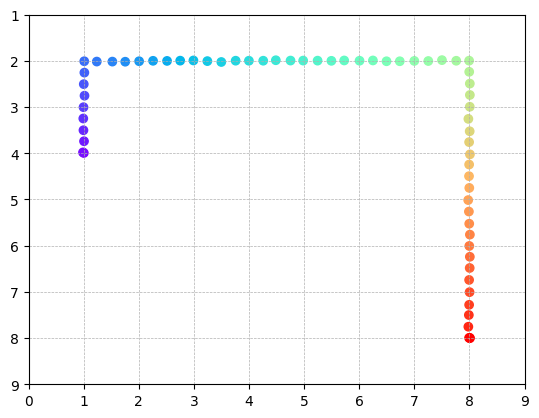

tensor([[[1.2769, 3.7373],
         [1.1020, 4.1052],
         [0.8731, 3.5341],
         [0.6117, 3.0132],
         [0.7150, 3.1306],
         [0.7482, 2.7066],
         [1.2253, 2.0786],
         [1.0766, 2.7315],
         [0.6499, 2.1090],
         [0.6986, 1.8305],
         [1.6071, 1.8727],
         [1.6292, 2.1741],
         [1.9049, 2.1725],
         [1.6339, 1.9768],
         [2.3827, 2.0703],
         [2.5993, 1.9540],
         [2.6187, 1.6124],
         [2.8878, 1.7476],
         [3.1140, 1.7787],
         [3.1780, 2.1539],
         [3.5064, 2.3868],
         [3.7433, 1.6249],
         [3.9263, 2.3927],
         [4.3114, 1.7091],
         [4.8400, 1.6873],
         [5.4471, 1.9007],
         [4.8725, 1.7773],
         [5.3930, 2.0845],
         [5.7198, 1.8521],
         [6.1568, 1.8857],
         [6.6233, 1.9814],
         [6.4326, 2.2489],
         [6.5636, 2.0237],
         [7.0591, 2.0501],
         [6.9228, 1.7277],
         [7.4469, 1.8737],
         [7.8406, 1.6592],
 

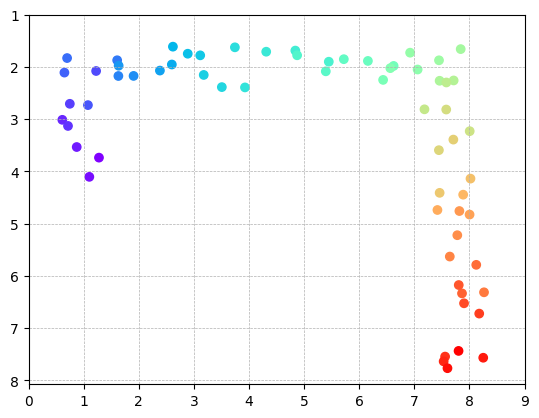

tensor([[[1.0680, 3.7275],
         [0.8333, 3.0128],
         [0.0670, 2.9232],
         [0.2721, 3.0932],
         [0.9218, 2.9845],
         [0.5743, 2.1405],
         [1.9163, 2.4518],
         [1.0081, 2.2114],
         [1.0936, 2.2335],
         [0.6544, 1.0996],
         [1.0163, 1.8744],
         [1.7699, 2.7657],
         [0.9971, 1.8838],
         [1.5669, 1.8627],
         [2.4570, 1.5715],
         [2.1605, 2.6798],
         [2.1265, 1.5440],
         [2.8022, 1.6823],
         [2.6717, 1.7428],
         [3.3379, 2.2324],
         [3.0844, 2.1209],
         [2.8695, 1.7624],
         [3.1565, 1.6388],
         [3.4727, 2.0167],
         [4.3952, 2.6604],
         [4.4620, 2.4418],
         [5.0766, 2.1220],
         [4.9427, 1.6713],
         [5.4491, 1.5104],
         [5.2933, 1.5780],
         [6.6153, 1.7569],
         [5.7471, 2.1782],
         [5.5993, 2.0878],
         [6.5787, 1.5646],
         [6.1154, 2.3505],
         [6.6985, 1.4095],
         [6.5672, 2.0488],
 

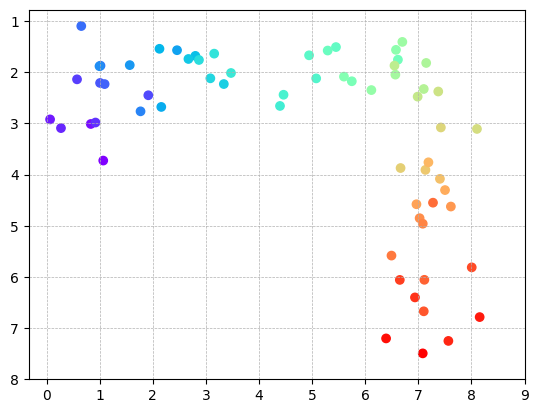

tensor([[[ 1.0901,  3.7760],
         [ 1.6503,  2.6214],
         [ 1.5456,  2.2766],
         [ 0.1075,  2.1621],
         [ 0.5476,  3.8532],
         [ 0.6969,  1.4162],
         [ 1.1120,  3.8295],
         [ 0.3973,  2.4929],
         [ 0.7345,  1.3639],
         [-0.2210,  0.7079],
         [ 0.7650,  3.3601],
         [ 0.6846,  1.9530],
         [ 0.7960,  2.2395],
         [ 1.4340,  2.1504],
         [ 1.2748,  1.2435],
         [ 0.8776,  1.5359],
         [ 2.1155,  2.0642],
         [ 1.3523,  1.8066],
         [ 1.8248,  0.3551],
         [ 2.8747,  1.0610],
         [ 3.8190,  1.5839],
         [ 3.1877,  1.3735],
         [ 2.7451,  1.6254],
         [ 3.6928,  1.6753],
         [ 3.2265,  1.6124],
         [ 4.0967,  3.1041],
         [ 3.5355,  1.7946],
         [ 3.6437,  1.2327],
         [ 3.8855,  2.2973],
         [ 4.4138,  2.5895],
         [ 3.8590,  2.0798],
         [ 3.6945,  1.5847],
         [ 4.9296,  1.3203],
         [ 6.6612,  1.2597],
         [ 6.5

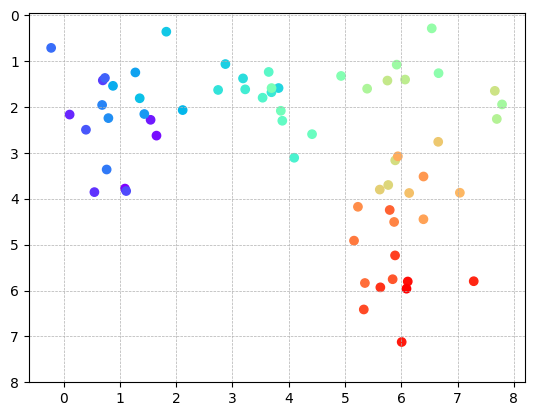

tensor([[[ 1.8949,  0.5358],
         [-0.6054, -0.7681],
         [-1.7132, -0.8722],
         [-0.1697, -0.6002],
         [ 0.6334,  2.8127],
         [ 0.9690, -0.2424],
         [ 1.0671,  0.7058],
         [ 0.6613,  0.7980],
         [ 3.0396, -0.2399],
         [ 0.5577, -1.3096],
         [-1.0412, -0.5116],
         [ 0.4460, -0.8748],
         [ 1.6347, -0.3366],
         [ 1.7821,  1.0352],
         [ 1.2345,  1.7494],
         [ 0.0456, -0.3500],
         [ 0.4194, -0.6575],
         [ 1.9517,  1.3790],
         [ 1.5407,  2.5236],
         [ 0.1979,  0.1404],
         [ 1.1703, -1.5828],
         [ 1.0889,  1.0270],
         [ 0.2712,  0.7711],
         [ 0.6952,  0.5647],
         [ 0.2772, -0.8414],
         [ 0.8200,  0.3421],
         [ 1.0987, -0.6158],
         [ 1.8447, -0.4145],
         [ 1.9574,  0.8568],
         [ 1.0726,  0.3840],
         [ 1.4262,  2.6963],
         [ 3.0434,  0.5515],
         [ 2.9522,  0.7682],
         [ 1.7384, -0.1321],
         [ 2.2

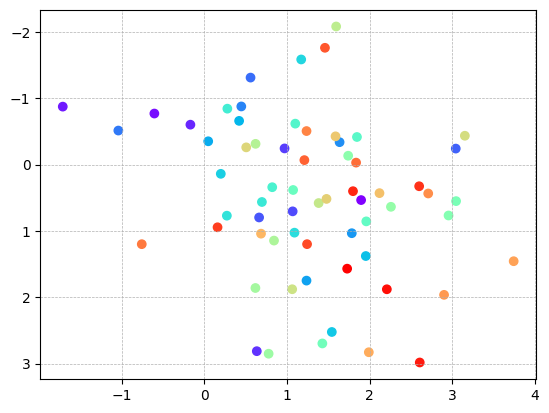

tensor([[[-1.5746e+00, -2.6785e-03],
         [ 2.5349e-01,  4.7322e-02],
         [ 3.1294e-01,  1.0816e+00],
         [-1.8016e-01,  2.4811e+00],
         [-1.4716e+00, -9.6320e-01],
         [ 8.8987e-03,  2.4968e+00],
         [-1.2726e+00, -5.0828e-01],
         [-6.2947e-02,  2.1120e-01],
         [-1.4120e-01, -1.4390e+00],
         [ 4.5911e-01, -1.2227e-01],
         [ 1.1951e+00,  3.6994e-01],
         [-6.9414e-01,  1.7989e-01],
         [-2.5305e-01,  8.4310e-01],
         [-5.1719e-01,  4.8879e-01],
         [ 1.6695e+00,  8.8725e-01],
         [-7.4160e-01,  1.0641e+00],
         [ 6.7930e-01, -1.6449e-01],
         [-8.3132e-01, -4.4171e-01],
         [ 4.0864e-01, -1.8803e+00],
         [ 2.8209e-01, -5.9070e-01],
         [-1.8159e+00, -9.2970e-01],
         [ 1.2474e+00,  5.2446e-01],
         [ 1.1070e+00,  1.3265e+00],
         [ 1.2899e+00,  4.0898e-01],
         [-1.2048e+00, -1.9825e-01],
         [ 8.9329e-01, -8.1190e-01],
         [ 6.9295e-01, -8.9181e-01],
 

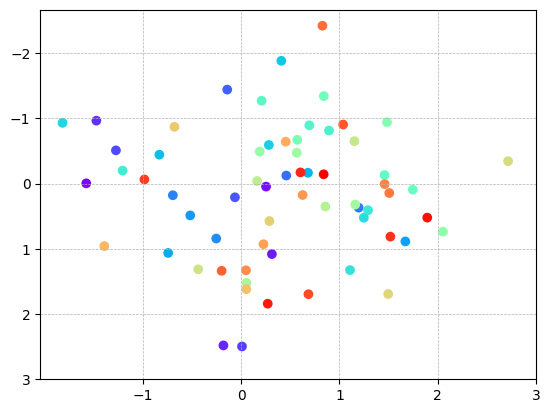

In [22]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])
from diffusion_features.utils.get_trajectories import visualize_trajectory
# normalize the x_start by the size of the maze which is 8
print(x_start.shape)
# reduce the length of the trajectory to 16
x_start = x_start[:, :64, :]
# x_start_normalized = x_start / 8
# print(torch.mean(x_start_normalized))
# print(torch.std(x_start_normalized))
# # make them in range [-1, 1]
# x_start_normalized = (x_start_normalized * 2) - 1
# print(x_start_normalized)

for t in [0, 50, 100, 150, 400, 499]:
  x_noisy = get_noisy_image(x_start, torch.tensor([t]))
  print(x_noisy)
    # print the mean and std of the noisy image
    # print(torch.mean(x_noisy))
    # print(torch.std(x_noisy))
  visualize_trajectory(x_noisy)

In [23]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1", condition=None):
    if noise is None:
        noise = torch.randn_like(x_start)
        
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    # print("x_noisy", x_noisy.shape)
    predicted_noise = denoise_model(x_noisy, t, global_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [24]:
@torch.no_grad()
def p_sample(model, x, t, t_index, global_cond=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, global_cond) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape, global_cond=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, global_cond=global_cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

@torch.no_grad()
def sample_trajectories(model, traj_size, batch_size=16, output_dim = 2, global_cond=None):
    return p_sample_loop(model, shape=(batch_size, traj_size, output_dim), global_cond=global_cond)


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [25]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [26]:
# Taken from https://diffusion-policy.cs.columbia.edu/
import logging
import math
from typing import List, Optional, Tuple, Union
import typing

import torch
from torch import nn

# @markdown ### **Network**
# @markdown
# @markdown Defines a 1D UNet architecture `ConditionalUnet1D`
# @markdown as the noies prediction network
# @markdown
# @markdown Components
# @markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
# @markdown - `Downsample1d` Strided convolution to reduce temporal resolution
# @markdown - `Upsample1d` Transposed convolution to increase temporal resolution
# @markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
# @markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
# @markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
# @markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        # print('emb shape:', emb.shape)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups,),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups,),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels,), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1,)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim: int,
        global_cond_dim: int,
        down_dims: List[int],
        diffusion_step_embed_dim: int,
        kernel_size: int = 5,
        n_groups: int = 8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines number of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size, n_groups=n_groups),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        global_cond: Optional[torch.Tensor] = None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B, global_cond_dim)
        output: (B,T,input_dim)
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        # (B,T,C)
        sample = sample.moveaxis(-1, -2)
        # print('sample shape:', sample.shape)

        # 1. time
        timesteps = timestep
        if timesteps.shape == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])
        timesteps = timesteps.to(sample.device)

        global_feature = self.diffusion_step_encoder(timesteps)
        global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        # print('downsampling')
        for resnet, resnet2, downsample in self.down_modules:
            # print('x shape:', x.shape)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            # print('h shape:', h[-1].shape)
            x = downsample(x)


        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)
        # print('upsampling')
        for resnet, resnet2, upsample in self.up_modules:
            # print('x shape:', x.shape)
            # print('h shape:', h[-1].shape)
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)
        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

In [27]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
# trajectories = trajectories[0:32]
trajectories = trajectories[:500]
# reduce the trajectory size to 16
trajectories = trajectories[:, :32, :]
trajectories_size = trajectories.shape
print(trajectories_size)
# model = Unet(
#     dim=trajectories_size[1],
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# TODO: double check down_dims
model = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=0,
    # global_cond_dim=4,
    down_dims=[16, 32, 64],
    diffusion_step_embed_dim=trajectories_size[1],
    kernel_size=3,
    n_groups=1,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

torch.Size([500, 32, 2])


Let's start training!

In [28]:
# print the total number of trajectories
print(trajectories.shape)


torch.Size([500, 32, 2])


In [29]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader

epochs = 300
batch_size = 32
# channels = 1
dataloader = DataLoader(trajectories, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
   loss_arr = []
   for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      
      
      b = batch.shape[0]
      batch = batch.to(device)
      # batch shape: (B, T, C)
      # print('input shape pre reshape', batch.shape)

      # batch = batch.reshape(b, channels, batch.shape[1], batch.shape[2])
      
      # normalize the batch to [-1, 1]
      batch = (batch / 8) * 2 - 1
      
      # generate conditioning based on start and end states
      start_states = batch[:, 0, :]
      end_states = batch[:, -1, :]
      condition = torch.cat((start_states, end_states), axis=1)
      # print(condition)
      condition = None
      # print('condition shape', condition.shape)
      
      # print("batch: ", torch.mean(batch[4]), torch.std(batch[4]))
      # print("Max and min", torch.max(batch[4]), torch.min(batch[4]))

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      if b != batch_size:
         continue
      loss = p_losses(model, batch, t, loss_type="huber", condition=condition)

      # if step % 100 == 0:
      # print("Loss:", loss.item())
      
      loss_arr.append(loss.item())

      loss.backward()
      optimizer.step()
   print(f"Loss for epoch {epoch}: {np.mean(loss_arr)}")
      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_57329/397776207.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)


Loss for epoch 0: 0.3835716168085734
Loss for epoch 1: 0.2758542130390803
Loss for epoch 2: 0.18389296134312946
Loss for epoch 3: 0.11547999282677969
Loss for epoch 4: 0.08492536544799804
Loss for epoch 5: 0.07188464378317197
Loss for epoch 6: 0.06554139753182729
Loss for epoch 7: 0.05452932814757029
Loss for epoch 8: 0.05595470294356346
Loss for epoch 9: 0.0547753428419431
Loss for epoch 10: 0.050565167268117266
Loss for epoch 11: 0.04807712733745575
Loss for epoch 12: 0.04832334145903587
Loss for epoch 13: 0.042517908414204914
Loss for epoch 14: 0.03898254868884881
Loss for epoch 15: 0.03860821997125943
Loss for epoch 16: 0.041960676883657774
Loss for epoch 17: 0.040054760749141376
Loss for epoch 18: 0.04073972863455613
Loss for epoch 19: 0.03983417935669422
Loss for epoch 20: 0.033234275256594024
Loss for epoch 21: 0.035254059731960295
Loss for epoch 22: 0.03622552007436752
Loss for epoch 23: 0.03286636384824912
Loss for epoch 24: 0.03551038503646851
Loss for epoch 25: 0.03801673389

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [30]:
global_cond = torch.tensor([2, 2, 7, 4]).unsqueeze(0).to(device)
# convert condition to [-1, 1]
global_cond = (global_cond / 8) * 2 - 1
# print(global_cond)
global_cond = None
samples = sample_trajectories(model=model, traj_size=32, batch_size=1, output_dim=2, global_cond=global_cond)
print(len(samples))

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_57329/397776207.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)
sampling loop time step: 100%|██████████| 500/500 [00:01<00:00, 433.85it/s]

500


(1, 32, 2)
[[[ 1.39847994e-01  2.92116880e+00]
  [ 8.32457781e-01 -1.46496201e+00]
  [ 1.88567686e+00  1.07134914e+00]
  [ 2.00359917e+00  4.05124092e+00]
  [ 2.10711813e+00  1.45275307e+00]
  [ 5.34793043e+00  5.63760471e+00]
  [ 8.24755955e+00  6.38855076e+00]
  [ 4.42053556e+00  3.76058578e+00]
  [-1.02006912e+00  7.29490900e+00]
  [ 3.85371709e+00  9.81569862e+00]
  [ 1.11947346e+00  3.30293894e+00]
  [ 6.06082773e+00  4.68370581e+00]
  [ 1.43741131e-01  1.16377125e+01]
  [ 2.96796989e+00  2.16432095e+00]
  [-2.66824818e+00  1.47340941e+00]
  [-5.41483879e+00  1.38624296e+01]
  [ 5.63401413e+00  6.65943050e+00]
  [ 2.78823185e+00  5.22153616e+00]
  [ 6.48130417e-01  4.73097324e-01]
  [-6.12700844e+00  6.94425154e+00]
  [ 1.17783689e+00  4.86232615e+00]
  [-1.87273026e-02  7.43324137e+00]
  [ 9.89653587e-01  4.65693378e+00]
  [ 8.88341522e+00  9.75115299e+00]
  [ 6.25593185e+00  4.42943621e+00]
  [ 2.88037896e+00 -5.56441784e-01]
  [ 8.85162354e-01  1.91069746e+00]
  [ 3.27891040e+0

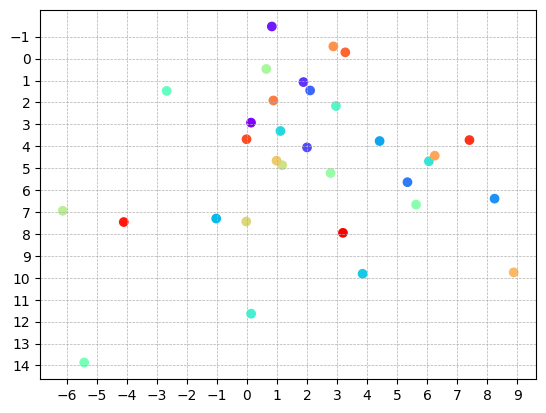

(1, 32, 2)
[[[ 3.0115957   2.4872437 ]
  [ 2.8072672  -0.15732956]
  [ 3.1732218   3.0612652 ]
  [ 1.6740868   3.566054  ]
  [ 4.926008   -2.1041212 ]
  [ 3.9616888   8.8973675 ]
  [10.4002075   7.858666  ]
  [ 3.6626868   4.0927677 ]
  [-3.4453087   7.5156355 ]
  [ 1.3377342  13.754556  ]
  [ 6.7797995   0.8316407 ]
  [ 3.389321    7.9716334 ]
  [-1.3396983   3.910018  ]
  [ 4.285201    3.3046684 ]
  [-1.5510478  -2.9132628 ]
  [-4.934579    7.835969  ]
  [ 5.4487724  10.048374  ]
  [ 4.7451715   4.2675605 ]
  [ 9.587959    5.596422  ]
  [ 1.7464786   3.2757194 ]
  [ 3.9163904   5.309463  ]
  [ 2.8362017   7.9724493 ]
  [-0.06424141  0.21434093]
  [ 6.7366643   5.4149475 ]
  [ 5.234818    1.6532569 ]
  [ 3.3511565  -4.962081  ]
  [ 5.2783318   0.9736371 ]
  [ 2.2586527   0.9287436 ]
  [ 0.9553504   4.0588427 ]
  [10.769505    2.3020399 ]
  [ 3.4175482   6.988471  ]
  [ 6.2959814   5.1075306 ]]]


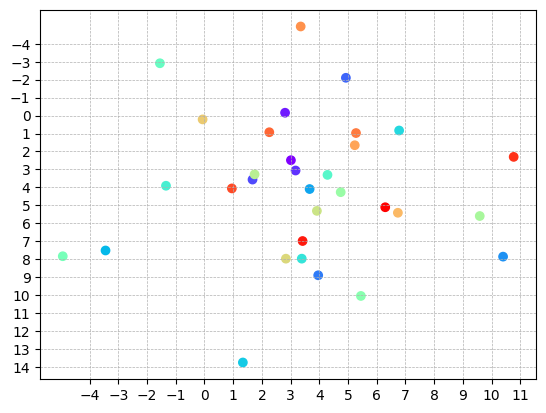

(1, 32, 2)
[[[ 4.145883    7.4907484 ]
  [ 3.8198898   4.3117285 ]
  [ 1.1884587   1.1823499 ]
  [-0.37718725  3.1007442 ]
  [ 3.9764018  -1.2257476 ]
  [ 5.0925703   7.6008954 ]
  [ 4.954845   12.997515  ]
  [ 3.326658    4.322277  ]
  [ 0.21032715  2.8849797 ]
  [ 4.0288057  11.906845  ]
  [ 1.6576314   0.72507334]
  [ 0.45869398  6.5818377 ]
  [-0.8982506   6.7255955 ]
  [ 4.5146184   0.19179344]
  [ 2.5706584  -0.83359814]
  [-1.9567313   9.216275  ]
  [ 5.312868    4.898577  ]
  [ 1.715548   10.2759695 ]
  [ 4.2984657   8.945101  ]
  [ 6.825718    2.4687037 ]
  [ 1.8401804   6.9542284 ]
  [-1.080843    6.41185   ]
  [ 3.462643   -3.772605  ]
  [ 5.333457    3.8052769 ]
  [ 7.1067834   4.082145  ]
  [ 4.9704266  -1.7570624 ]
  [ 7.396223    7.398615  ]
  [ 7.4661913  -0.1310072 ]
  [ 4.4531336   7.120808  ]
  [ 9.88813     4.530475  ]
  [ 9.50136     6.068957  ]
  [ 5.457073    2.942425  ]]]


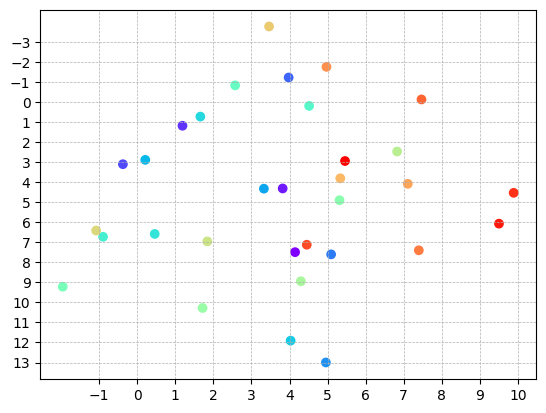

(1, 32, 2)
[[[ 9.129562    6.5860796 ]
  [ 1.3299661  -0.21199036]
  [-1.9532266   1.5136039 ]
  [ 4.998514    5.8045483 ]
  [ 3.345072    2.712821  ]
  [ 7.172955    6.249179  ]
  [ 2.8249512   3.9749503 ]
  [ 1.6081622   3.7790532 ]
  [ 5.41403     4.727283  ]
  [ 3.5673296  -1.4489336 ]
  [ 3.3230968   1.8434057 ]
  [ 2.2578878   5.6764436 ]
  [ 0.601423    5.756171  ]
  [ 1.783124   -1.26022   ]
  [ 0.48954463  1.5431182 ]
  [-4.1163054   9.265982  ]
  [-0.25663757  6.7279177 ]
  [-2.2425709   4.162284  ]
  [ 4.653123    6.929489  ]
  [-3.1783876  -0.97766113]
  [ 5.38102    -0.02792311]
  [ 4.2203054   6.4009814 ]
  [ 9.833958   -8.10536   ]
  [ 3.8051746   5.0839763 ]
  [ 6.3772106   0.7541373 ]
  [ 2.773556    1.8779602 ]
  [13.27354    -3.7009768 ]
  [-1.0932765  -1.7112908 ]
  [-0.39853573  5.89935   ]
  [ 6.875887    3.5491714 ]
  [ 7.1888485   4.0483456 ]
  [ 5.110004    1.0737343 ]]]


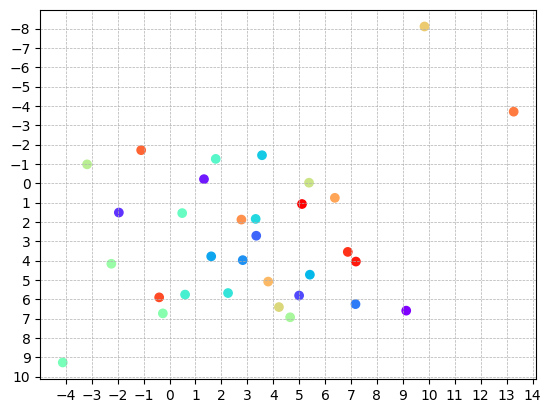

(1, 32, 2)
[[[ 2.15639639e+00  1.21257019e+00]
  [ 3.90700555e+00  4.24641657e+00]
  [-4.91220474e-01  2.41145372e+00]
  [ 4.09644365e-01  1.84828496e+00]
  [ 1.74348974e+00  1.40976119e+00]
  [ 1.89655733e+00 -6.84151649e-02]
  [ 2.64980555e+00  3.39664459e+00]
  [-1.02277946e+00  1.09932828e+00]
  [ 1.25448751e+00  2.34756660e+00]
  [ 2.94551849e-01  3.92515421e-01]
  [ 1.54997730e+00  2.52348614e+00]
  [ 3.74499416e+00  3.41885781e+00]
  [ 1.16415739e+00  3.51627302e+00]
  [ 1.16943955e+00  3.82341003e+00]
  [ 1.55765486e+00 -2.65359879e-03]
  [-1.46160030e+00  1.69956970e+00]
  [ 4.06984568e-01  3.00405836e+00]
  [ 4.11303663e+00  6.61191940e-01]
  [ 1.42960787e+00  3.37781429e+00]
  [ 2.71373105e+00  2.00562286e+00]
  [ 6.76697254e-01  5.97819948e+00]
  [ 4.45577955e+00  7.42666245e-01]
  [ 4.18866968e+00  1.30835223e+00]
  [ 2.55387306e+00  3.90894341e+00]
  [ 2.67770696e+00 -1.15260124e-01]
  [ 4.49918461e+00  5.39838552e+00]
  [ 6.31827497e+00  3.43402743e+00]
  [-1.99107647e-0

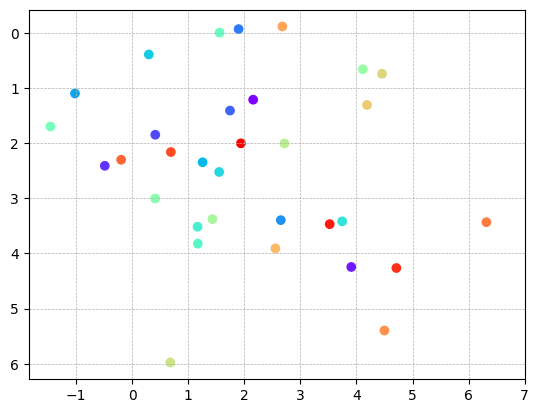

(1, 32, 2)
[[[1.2708023 1.3491838]
  [1.2714875 1.3730571]
  [1.2608879 1.4441614]
  [1.2404203 1.4262571]
  [1.2494755 1.4205489]
  [1.2565107 1.4334252]
  [1.2519324 1.4622712]
  [1.2399564 1.492418 ]
  [1.2578111 1.4600053]
  [1.2570117 1.4329262]
  [1.2697475 1.4118695]
  [1.2792344 1.4111152]
  [1.2809443 1.4625454]
  [1.2834637 1.5288255]
  [1.2656767 1.6601391]
  [1.2138965 1.7982006]
  [1.2823913 1.9429185]
  [1.3574393 2.075379 ]
  [1.5517089 2.0892177]
  [1.7626159 2.1051896]
  [1.9519587 2.0105302]
  [2.1366408 1.9526408]
  [2.274467  2.0446162]
  [2.3873487 2.1602159]
  [2.4719315 2.3680162]
  [2.4844134 2.5854182]
  [2.5464718 2.6950006]
  [2.561093  2.8045754]
  [2.735401  2.825448 ]
  [2.8830562 2.893092 ]
  [3.0407495 3.0308123]
  [3.1156192 3.1776571]]]


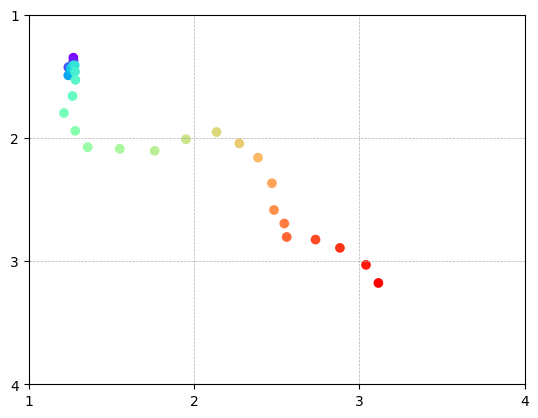

In [32]:
# show a random one
from diffusion_features.utils.get_trajectories import visualize_trajectory
import numpy as np

# random_index = 180
# print(samples[random_index].shape)
# print(samples[random_index])
# random_sample = samples[random_index][0]
# print(np.mean(random_sample))
# print(np.std(random_sample))
# # plot the trajectory
# visualize_trajectory(random_sample)

# print the final trajectory
# samples[-1] = ((samples[-1]+1)/2) * 8 # denormalize
# print(samples[-1].shape)
# print(samples[-1])
# visualize_trajectory(samples[-1])


for i in [0, 50, 100, 200, 400, 499]:
  samples[i] = ((samples[i]+1)/2) * 8 # denormalize
  print(samples[i].shape)
  print(samples[i])
  visualize_trajectory(samples[i][:10])

<img src="https://drive.google.com/uc?id=1ytnzS7IW7ortC6ub85q7nud1IvXe2QTE" width="300" />